In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import tensorflow as tf

import sys
sys.path.append('/mnt/c/Users/kheut/code/covid19-forecasting/tf_model_1p5/')

from enum import Enum

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense

import tensorflow_probability as tfp
from scipy.stats import beta, truncnorm


# Local imports from model.py, data.py
from model import CovidModel, LogPoissonProb, get_logging_callbacks, Comp, Vax
from model_config import ModelConfig
from data import read_data, create_warmup
#from plots import make_all_plots

import scipy

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20}) # set plot font sizes

2022-03-14 02:23:41.398843: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-14 02:23:41.398881: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [35]:
transition_window =10

warmup_start = '20210421'
warmup_end = '20210430'
train_start = '20210501'
train_end = '20210731'
test_start = '20210801'
test_end = '20210831'

state = 'Massachusetts'
state_abbrev = 'MA'

data_dir = '../data'
covid_estim_date = '20210901'
hhs_date = '20210903'
owid_date = '20210903'

# Learning rate
learning_rate = 0.001

In [3]:
df = read_data(data_dir=data_dir,
               covid_estim_date=covid_estim_date,
               hhs_date=hhs_date,
               owid_date=owid_date,
               state=state, state_abbrev=state_abbrev)
vax_statuses = [Vax.yes, Vax.no]
x_train = tf.cast(df.loc[train_start:train_end,'Rt'].values, dtype=tf.float32)
x_test = tf.cast(df.loc[train_start:test_end,'Rt'].values, dtype=tf.float32)


y_train = {}
y_train['G_in'] = tf.cast(df.loc[train_start:train_end,'general_ward_in'], dtype=tf.float32)
y_train['G_count'] = tf.cast(df.loc[train_start:train_end,'general_ward_count'], dtype=tf.float32)
y_train['I_count'] = tf.cast(df.loc[train_start:train_end,'icu_count'], dtype=tf.float32)
y_train['D_in'] = tf.cast(df.loc[train_start:train_end,'deaths_covid'], dtype=tf.float32) + 1

y_test = {}
y_test['G_in'] = tf.cast(df.loc[train_start:test_end,'general_ward_in'], dtype=tf.float32)
y_test['G_count'] = tf.cast(df.loc[train_start:test_end,'general_ward_count'], dtype=tf.float32)
y_test['I_count'] = tf.cast(df.loc[train_start:test_end,'icu_count'], dtype=tf.float32)
y_test['D_in'] = tf.cast(df.loc[train_start:test_end,'deaths_covid'], dtype=tf.float32)

2022-03-14 02:23:43.602767: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-14 02:23:43.603088: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-14 02:23:43.603148: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-03-14 02:23:43.603188: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-03-14 02:23:43.603234: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

In [4]:
config = ModelConfig.from_json('/mnt/c/Users/kheut/code/covid19-forecasting/tf_model_1p5/model_config.json')

In [5]:
config

In [6]:
model = CovidModel([Vax.no, Vax.yes], [Comp.A, Comp.M, Comp.G, Comp.GR, Comp.I, Comp.IR, Comp.D],
                 transition_window,
                config, posterior_samples=1000, debug_disable_theta=False,
                  fix_variance=True)

pre_training_preds=model.call(x_train)

2022-03-14 02:24:15.845234: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [36]:
loss = LogPoissonProb() 
optimizer = tf.keras.optimizers.Adam(
    learning_rate=learning_rate,#beta_1=0.1, beta_2=0.1
)
#loss((y_train['G_count'], y_train['G_in'], y_train['I_count'], y_train['D_in']), pre_training_preds)

In [37]:
logging_callbacks = get_logging_callbacks('/mnt/c/Users/kheut/logs/covid/new_vax_model_small/')

2022-03-14 15:43:38.249435: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-03-14 15:43:38.249516: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-03-14 15:43:38.253558: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1666] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2022-03-14 15:43:38.253610: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-03-14 15:43:38.253759: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1757] function cupti_interface_->Finalize()failed with error CUPTI could not be loaded or symbol could not be found.


In [38]:
model.compile(loss=loss, optimizer=optimizer, run_eagerly=True)
model.fit(x=np.asarray([x_train]), y=np.asarray([(y_train['G_count'], y_train['G_in'], y_train['I_count'], y_train['D_in'])]),
         epochs=2000, batch_size=0,
        callbacks=logging_callbacks)

Epoch 1/2000
G count: -11.251383781433105
G in: -4.191608428955078
I count: -6.616673946380615
D in: -2.1998226642608643
1/1 [==============================] - 43s 43s/step - loss: 67.8457
Epoch 2/2000


2022-03-14 15:44:24.847347: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-03-14 15:44:24.847381: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-03-14 15:44:24.847713: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1666] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.


G count: -11.634514808654785
G in: -4.210806369781494
I count: -6.919171333312988
D in: -2.208805561065674
1/1 [==============================] - ETA: 0s - loss: 68.4606

2022-03-14 15:45:19.771172: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-03-14 15:45:19.967647: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1757] function cupti_interface_->Finalize()failed with error CUPTI could not be loaded or symbol could not be found.
2022-03-14 15:45:23.802210: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-03-14 15:45:38.296343: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-03-14 15:45:54.224607: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /mnt/c/Users/kheut/logs/covid/new_vax_model_small/train/plugins/profile/2022_03_14_15_45_38

2022-03-14 15:45:55.484853: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to /mnt/c/Users/kheut/logs/covid/new_vax_model_small/train/plugins/profile/20

1/1 [==============================] - 96s 96s/step - loss: 68.4606
Epoch 3/2000
G count: -11.029327392578125
G in: -4.2065558433532715
I count: -6.464441776275635
D in: -2.205658197402954
1/1 [==============================] - 42s 42s/step - loss: 67.3860
Epoch 4/2000
G count: -11.34455680847168
G in: -4.228254795074463
I count: -6.736245155334473
D in: -2.2070300579071045
1/1 [==============================] - 42s 42s/step - loss: 67.8339
Epoch 5/2000
G count: -11.227302551269531
G in: -4.196227073669434
I count: -6.385443687438965
D in: -2.1902096271514893
1/1 [==============================] - 38s 38s/step - loss: 67.2650
Epoch 6/2000
G count: -11.475979804992676
G in: -4.2277302742004395
I count: -6.539303779602051
D in: -2.2035350799560547
1/1 [==============================] - 38s 38s/step - loss: 67.9502
Epoch 7/2000
G count: -11.62236213684082
G in: -4.228297233581543
I count: -6.337707996368408
D in: -2.2081081867218018
1/1 [==============================] - 38s 38s/step - lo

1/1 [==============================] - 40s 40s/step - loss: 67.8142
Epoch 46/2000
G count: -11.178303718566895
G in: -4.187342643737793
I count: -6.534778594970703
D in: -2.206458568572998
1/1 [==============================] - 39s 39s/step - loss: 67.4929
Epoch 47/2000
G count: -11.218045234680176
G in: -4.202655792236328
I count: -6.474215507507324
D in: -2.199551582336426
1/1 [==============================] - 41s 41s/step - loss: 67.8014
Epoch 48/2000
G count: -11.47673225402832
G in: -4.221125602722168
I count: -6.481513023376465
D in: -2.2012763023376465
1/1 [==============================] - 40s 40s/step - loss: 67.6608
Epoch 49/2000
G count: -11.130071640014648
G in: -4.1839518547058105
I count: -6.7598161697387695
D in: -2.203711748123169
1/1 [==============================] - 39s 39s/step - loss: 67.6439
Epoch 50/2000
G count: -11.401161193847656
G in: -4.187526702880859
I count: -6.3643083572387695
D in: -2.198647975921631
1/1 [==============================] - 38s 38s/step 

KeyboardInterrupt: 

In [ ]:
model.variables

Text(0.5, 1.0, 'ICU Count')

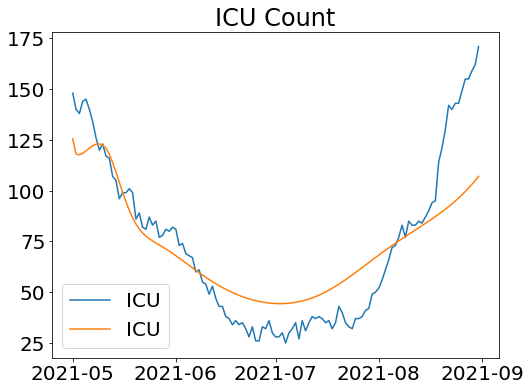

In [41]:
plt.figure(figsize=(8, 6))
preds=tf.reduce_mean(model.call(x_test), axis=-1)
plt.plot(df.loc[train_start:test_end].index.values, y_test['I_count'], label='ICU')
plt.plot(df.loc[train_start:test_end].index.values, preds[0][2], label='ICU')
month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.title('ICU Count')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Gen Count')

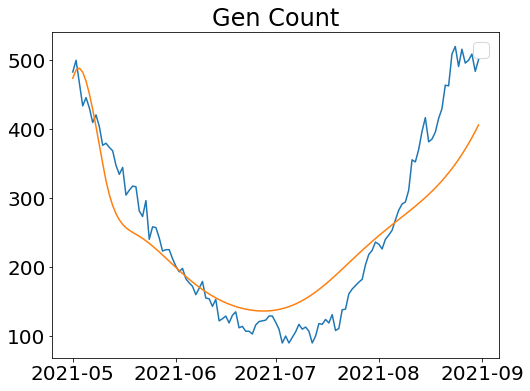

In [42]:
plt.figure(figsize=(8, 6))
plt.plot(df.loc[train_start:test_end].index.values, y_test['G_count'], )
plt.plot(df.loc[train_start:test_end].index.values, preds[0][0])
month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.title('Gen Count')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Gen Influx')

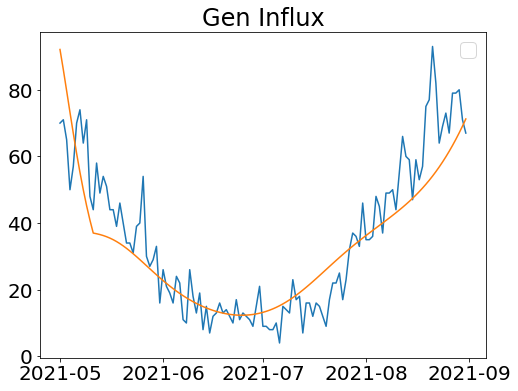

In [43]:
plt.figure(figsize=(8, 6))
plt.plot(df.loc[train_start:test_end].index.values, y_test['G_in'], )
plt.plot(df.loc[train_start:test_end].index.values, preds[0][1])
month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.title('Gen Influx')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Death Influx')

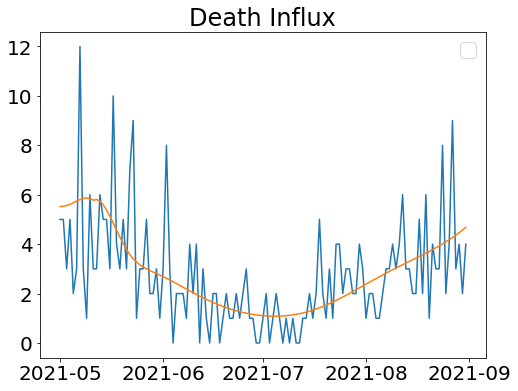

In [44]:
plt.figure(figsize=(8, 6))
plt.plot(df.loc[train_start:test_end].index.values, y_test['D_in'], )
plt.plot(df.loc[train_start:test_end].index.values, preds[0][3])
month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.title('Death Influx')

In [46]:
pred_draws = model.call(x_test)

In [81]:
numpy_draws  = pred_draws.numpy().squeeze()
pred_G_count = numpy_draws[0,:,:]
pred_G_in =  numpy_draws[1,:,:]
pred_I_count = numpy_draws[2,:,:]
pred_D_in = numpy_draws[3,:,:]

In [82]:
pred_G_count_lower, pred_G_count_mean, pred_G_count_upper = (np.percentile(pred_G_count,2.5, axis=1),
                                                             np.mean(pred_G_count, axis=1),
                                                             np.percentile(pred_G_count,97.5, axis=1))

pred_G_in_lower, pred_G_in_mean, pred_G_in_upper = (np.percentile(pred_G_in,2.5, axis=1),
                                                             np.mean(pred_G_in, axis=1),
                                                             np.percentile(pred_G_in,97.5, axis=1))

pred_I_count_lower, pred_I_count_mean, pred_I_count_upper = (np.percentile(pred_I_count,2.5, axis=1),
                                                             np.mean(pred_I_count, axis=1),
                                                             np.percentile(pred_I_count,97.5, axis=1))

pred_D_in_lower, pred_D_in_mean, pred_D_in_upper = (np.percentile(pred_D_in,2.5, axis=1),
                                                             np.mean(pred_D_in, axis=1),
                                                             np.percentile(pred_D_in,97.5, axis=1))

Text(0.5, 1.0, 'General Ward Census')

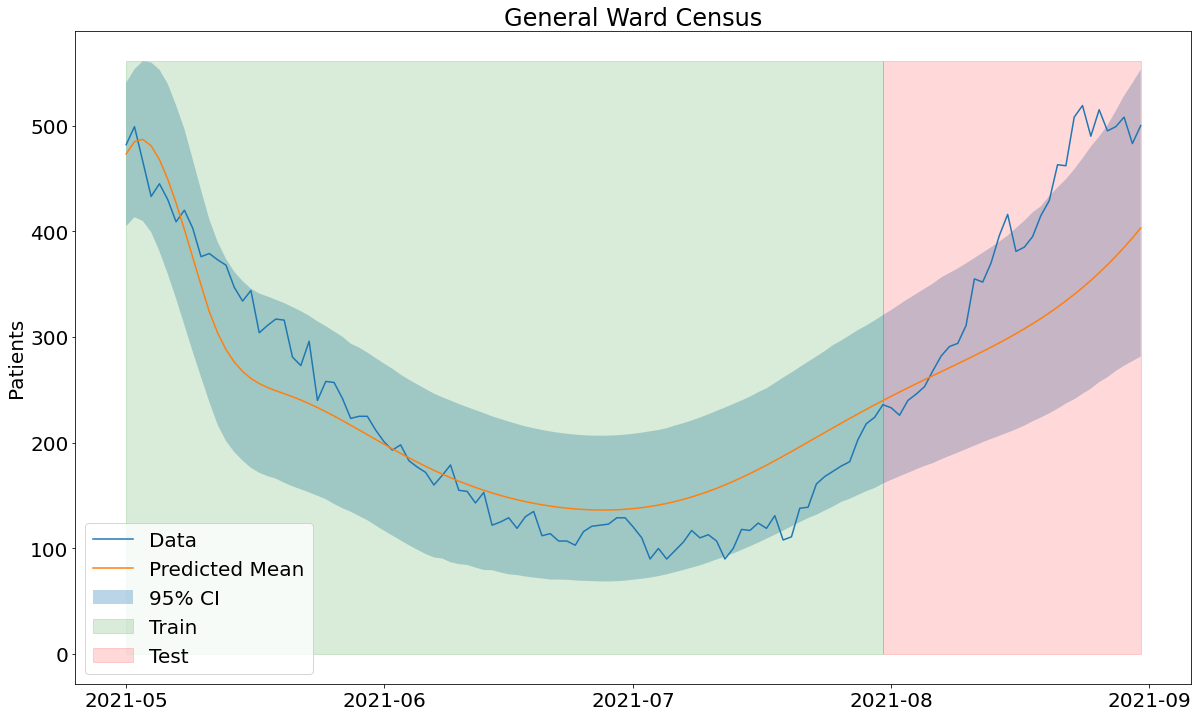

In [83]:
plt.figure(figsize=(20, 12))
plt.plot(df.loc[train_start:test_end].index.values, y_test['G_count'], label='Data')
plt.plot(df.loc[train_start:test_end].index.values, pred_G_count_mean, label='Predicted Mean')
plt.fill_between(df.loc[train_start:test_end].index.values, pred_G_count_lower, pred_G_count_upper,
                label='95% CI', alpha=0.3)

max_y = max(max(pred_G_count_upper), max(y_test['G_count']))
plt.fill_between(df.loc[train_start:train_end].index.values,0,max_y, alpha=0.15, color='green', label='Train')
plt.fill_between(df.loc[train_end:test_end].index.values,0,max_y, alpha=0.15, color='red', label='Test')

month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.ylabel('Patients')
plt.title('General Ward Census')

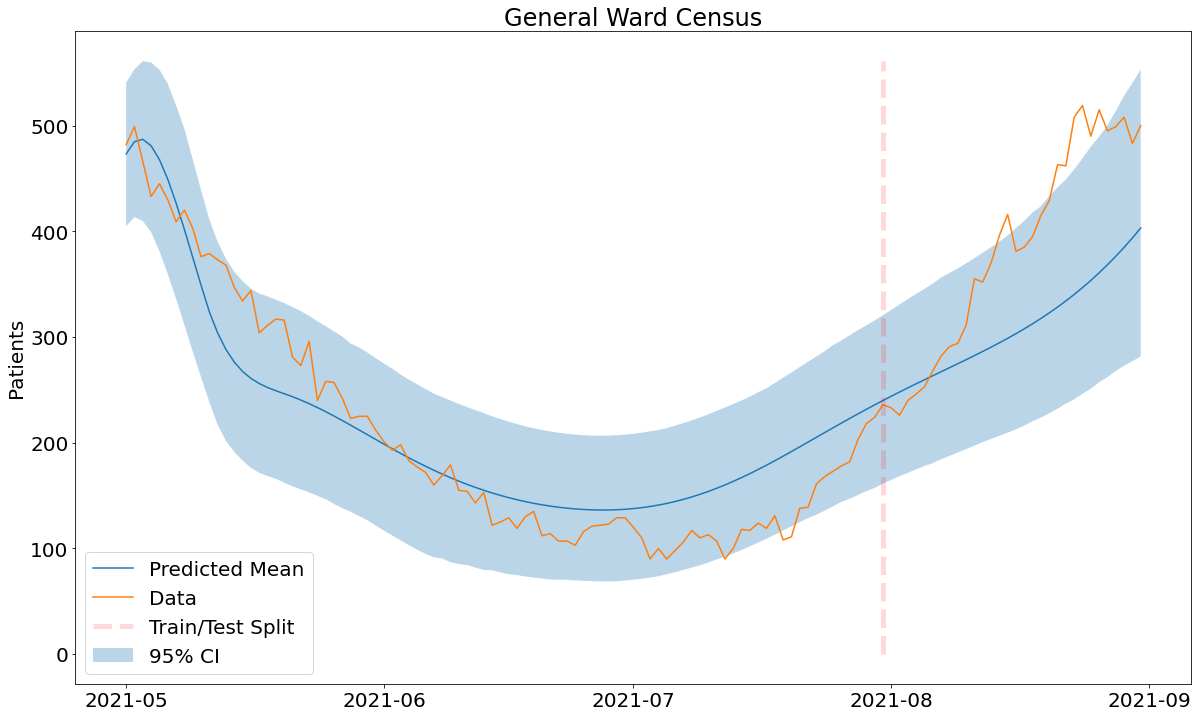

In [88]:
plt.figure(figsize=(20, 12))
plt.plot(df.loc[train_start:test_end].index.values, pred_G_count_mean, label='Predicted Mean')
plt.plot(df.loc[train_start:test_end].index.values, y_test['G_count'], label='Data')
plt.fill_between(df.loc[train_start:test_end].index.values, pred_G_count_lower, pred_G_count_upper,
                label='95% CI', alpha=0.3)

max_y = max(max(pred_G_count_upper), max(y_test['G_count']))
plt.plot([df.loc[train_end:train_end].index.values, df.loc[train_end:train_end].index.values], [0,max_y],
         '--', color='red',linewidth=5, alpha=0.15, label='Train/Test Split')

month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.ylabel('Patients')
plt.title('General Ward Census')
plt.savefig('G_count.png')

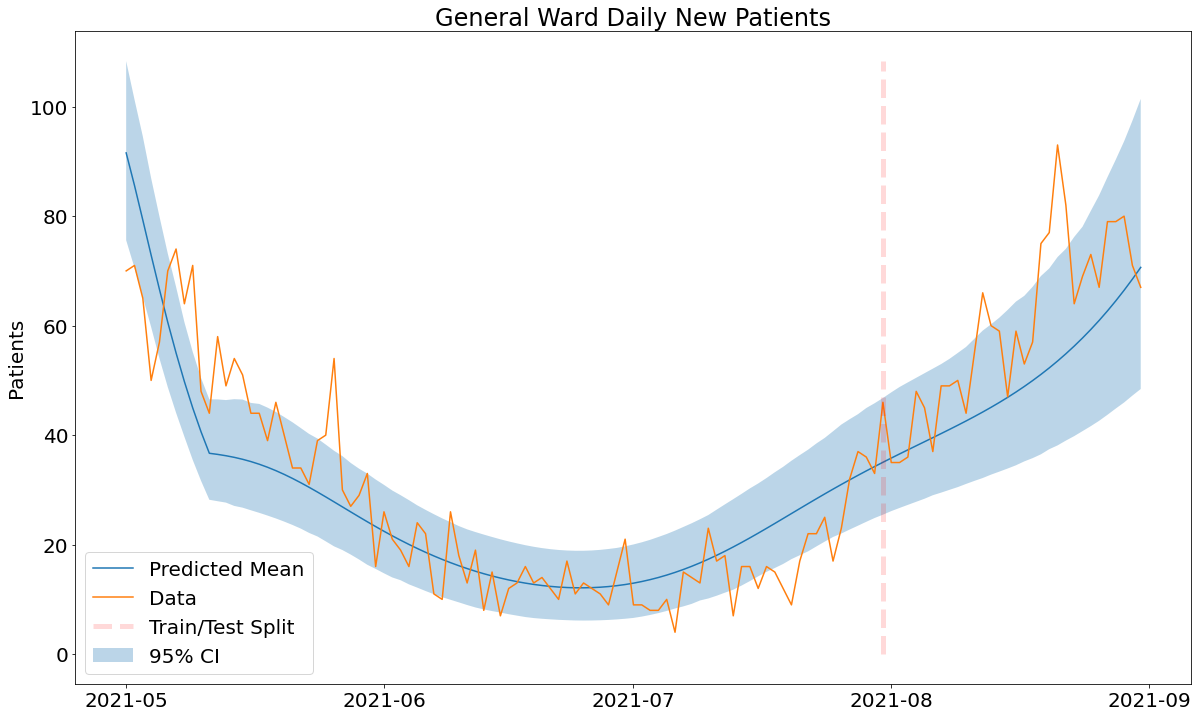

In [89]:
plt.figure(figsize=(20, 12))
plt.plot(df.loc[train_start:test_end].index.values, pred_G_in_mean, label='Predicted Mean')
plt.plot(df.loc[train_start:test_end].index.values, y_test['G_in'], label='Data')
plt.fill_between(df.loc[train_start:test_end].index.values, pred_G_in_lower, pred_G_in_upper,
                label='95% CI', alpha=0.3)

max_y = max(max(pred_G_in_upper), max(y_test['G_in']))
plt.plot([df.loc[train_end:train_end].index.values, df.loc[train_end:train_end].index.values], [0,max_y],
         '--', color='red',linewidth=5, alpha=0.15, label='Train/Test Split')

month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.ylabel('Patients')
plt.title('General Ward Daily New Patients')
plt.savefig('G_in.png')

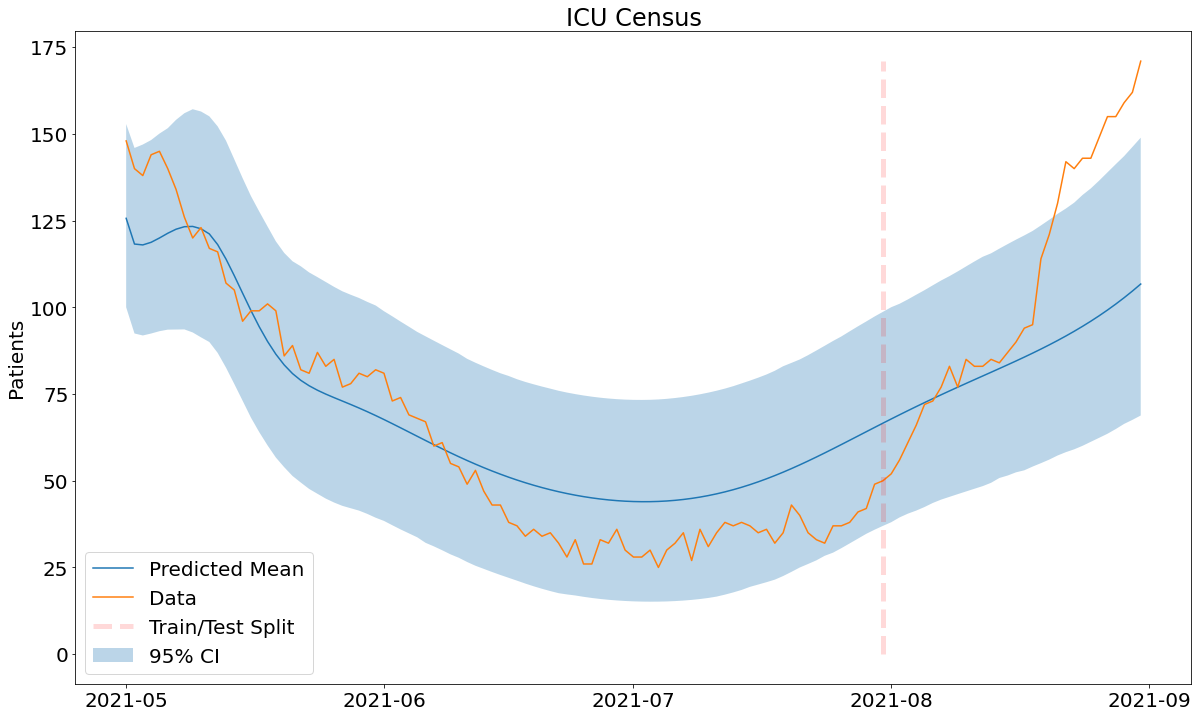

In [90]:
plt.figure(figsize=(20, 12))
plt.plot(df.loc[train_start:test_end].index.values, pred_I_count_mean, label='Predicted Mean')
plt.plot(df.loc[train_start:test_end].index.values, y_test['I_count'], label='Data')
plt.fill_between(df.loc[train_start:test_end].index.values, pred_I_count_lower, pred_I_count_upper,
                label='95% CI', alpha=0.3)

max_y = max(max(pred_I_count_upper), max(y_test['I_count']))
plt.plot([df.loc[train_end:train_end].index.values, df.loc[train_end:train_end].index.values], [0,max_y],
         '--', color='red',linewidth=5, alpha=0.15, label='Train/Test Split')

month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.ylabel('Patients')
plt.title('ICU Census')
plt.savefig('I_count.png')

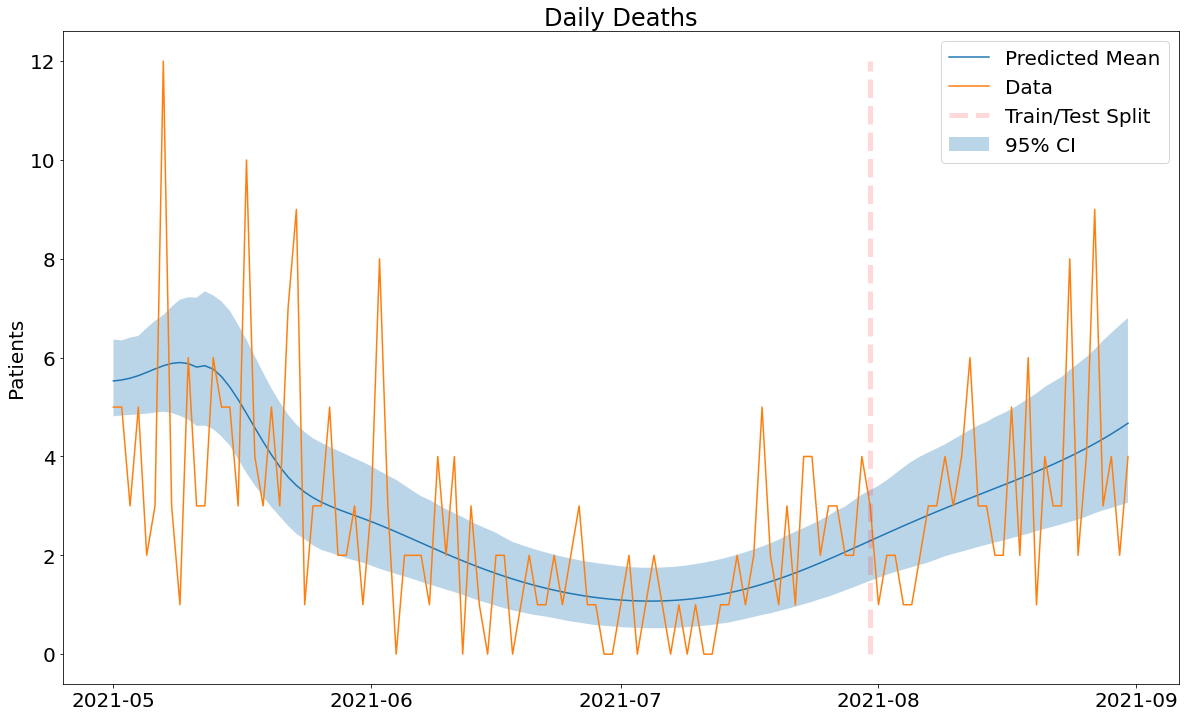

In [91]:
plt.figure(figsize=(20, 12))
plt.plot(df.loc[train_start:test_end].index.values, pred_D_in_mean, label='Predicted Mean')
plt.plot(df.loc[train_start:test_end].index.values, y_test['D_in'], label='Data')
plt.fill_between(df.loc[train_start:test_end].index.values, pred_D_in_lower, pred_D_in_upper,
                label='95% CI', alpha=0.3)

max_y = max(max(pred_D_in_upper), max(y_test['D_in']))
plt.plot([df.loc[train_end:train_end].index.values, df.loc[train_end:train_end].index.values], [0,max_y],
         '--', color='red',linewidth=5, alpha=0.15, label='Train/Test Split')

month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.ylabel('Patients')
plt.title('Daily Deaths')
plt.savefig('D_in.png')

In [40]:
new_config.to_json("/mnt/c/Users/kheut/code/covid19-forecasting/tf_model_1p5/after_training_eff.json")

In [ ]:
y_train

In [ ]:
model.init_count_G_params

In [ ]:
model.config.init_count_I.value

In [ ]:
new_config = model.config.update_from_model(model)

In [ ]:
new_config.to_json("/mnt/c/Users/kheut/Downloads/fix_after_600.json")

In [ ]:
model.variables

In [ ]:
model.init_count_G_params

In [ ]:
model.variables

In [ ]:
model.init_count_G_samples_constrained[0].numpy().min(), model.init_count_G_samples_constrained[0].numpy().max()

In [ ]:
tfp.bijectors.Softplus.inverse(17/100)

In [ ]:
new_config.init_count_I.value

In [ ]:
model.config.init_count_G.value[1]['scale']

In [ ]:
model.init_count_G_params

In [ ]:
tf.random.normal((1000, ))

In [72]:
[df.loc[train_end:train_end].index.values, df.loc[train_end:train_end].index.values]

[array(['2021-07-31T00:00:00.000000000'], dtype='datetime64[ns]'),
 array(['2021-07-31T00:00:00.000000000'], dtype='datetime64[ns]')]